In [15]:
import sys
sys.path.append("..")
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset, DataLoader
from torchvision import transforms
import PIL
from copy import deepcopy
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import math
import json
import gc
import warnings

from src.unet import UNet
from src.resnet2 import ResNet_D, ResNet_G
from src.plotters import plot_images
from src.tools import (load_dataset, downsample, upsample, freeze, unfreeze, 
                       calculate_cost, get_pushed_loader_stats, calculate_frechet_distance)
from torchvision.transforms import (Compose, Resize, Normalize, ToTensor, RandomCrop, 
                                    RandomHorizontalFlip, RandomVerticalFlip, Lambda, Pad, 
                                    CenterCrop, RandomResizedCrop, Pad)

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Main Config

In [7]:
DEVICE_ID = 0
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' #'cuda'
SEED = 0x000000

torch.manual_seed(SEED); np.random.seed(SEED)

# DATASET_12_LIST = [('ffhq_faces', '/gpfs/data/gpfs0/m.gazdieva/data/ffhq_faces/', 
#                     'comic_faces', '/gpfs/data/gpfs0/m.gazdieva/data/comic_faces/', 128)
#               ]

# DATASET_12_LIST = [('dtd', '/gpfs/data/gpfs0/m.gazdieva/data/textures/', 
#                     'chairs', '/gpfs/data/gpfs0/m.gazdieva/data/Bonn_Furniture_Styles_Dataset/houzz/chairs/', 64)
#               ]

# DATASET_12_LIST = [('handbag', '/gpfs/data/gpfs0/m.gazdieva/data/handbag_128.hdf5', 
#                     'shoes', '/gpfs/data/gpfs0/m.gazdieva/data/shoes_128.hdf5', 128)
#               ]


DATASET_12_LIST = [('celeba_female', '/gpfs/gpfs0/optimaltransport-lab/datasets/celeba/', 
                    'aligned_anime_faces', '/gpfs/data/gpfs0/m.gazdieva/data/aligned_anime_faces/', 64)
              ]

COST = 'mse'
W = 1
BATCH_SIZE = 64

if torch.cuda.is_available():
    torch.cuda.set_device(f'cuda:{DEVICE_ID}')

# Calculate Cost

In [3]:
T = UNet(3, 3, base_factor=48)
if torch.cuda.is_available():
    T.cuda()
T.eval();
freeze(T)

In [9]:
for (DATASET1, DATASET1_PATH, DATASET2, DATASET2_PATH, IMG_SIZE) in DATASET_12_LIST:
    print('Processing {}'.format(DATASET1))
    X_sampler, X_test_sampler = load_dataset(DATASET1, DATASET1_PATH, 
                                             img_size=IMG_SIZE, batch_size=16, device=DEVICE)
    del X_sampler
    print('Dataset {} loaded'.format(DATASET1))
    
    Y_sampler, Y_test_sampler = load_dataset(DATASET2, DATASET2_PATH, 
                                             img_size=IMG_SIZE, batch_size=16, device=DEVICE)
    del Y_sampler
    print('Dataset {} loaded'.format(DATASET2))
    
    PATH = '../state_dicts/{}_{}_{}_{}_{}_{}_{}.pt'.format(COST, DATASET1, DATASET2, 
                                                        IMG_SIZE, 64, 48, W)
    
    T.load_state_dict(torch.load(PATH))
    T.to(DEVICE)
    
    cost = 0
    if DATASET1 == 'dtd':
        for k in tqdm(range(50)):
            cost += calculate_cost(T, X_test_sampler.loader, verbose=False)
        cost = cost / 50
    else:
        cost = calculate_cost(T, X_test_sampler.loader, verbose=True, cost_type=COST)

    print(f'Mean Test Cost = {cost}')

Processing celeba_female
Dataset celeba_female loaded
Dataset aligned_anime_faces loaded



Mean Test Cost = 0.2968768632807438


In [13]:
freeze(T)
filename = '../stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
            
freeze(T);
mu, sigma = get_pushed_loader_stats(T, X_test_sampler.loader, n_epochs=1, device='cuda', verbose=True, upgrade=False)
fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
print('Mean Test FID = %.3f'%fid)


Mean Test FID = 14.657


# Plotting

## Celeba -> Anime

In [16]:
dataset = X_test_sampler.loader.dataset

### Illustration for experiment with bigger weights

196384

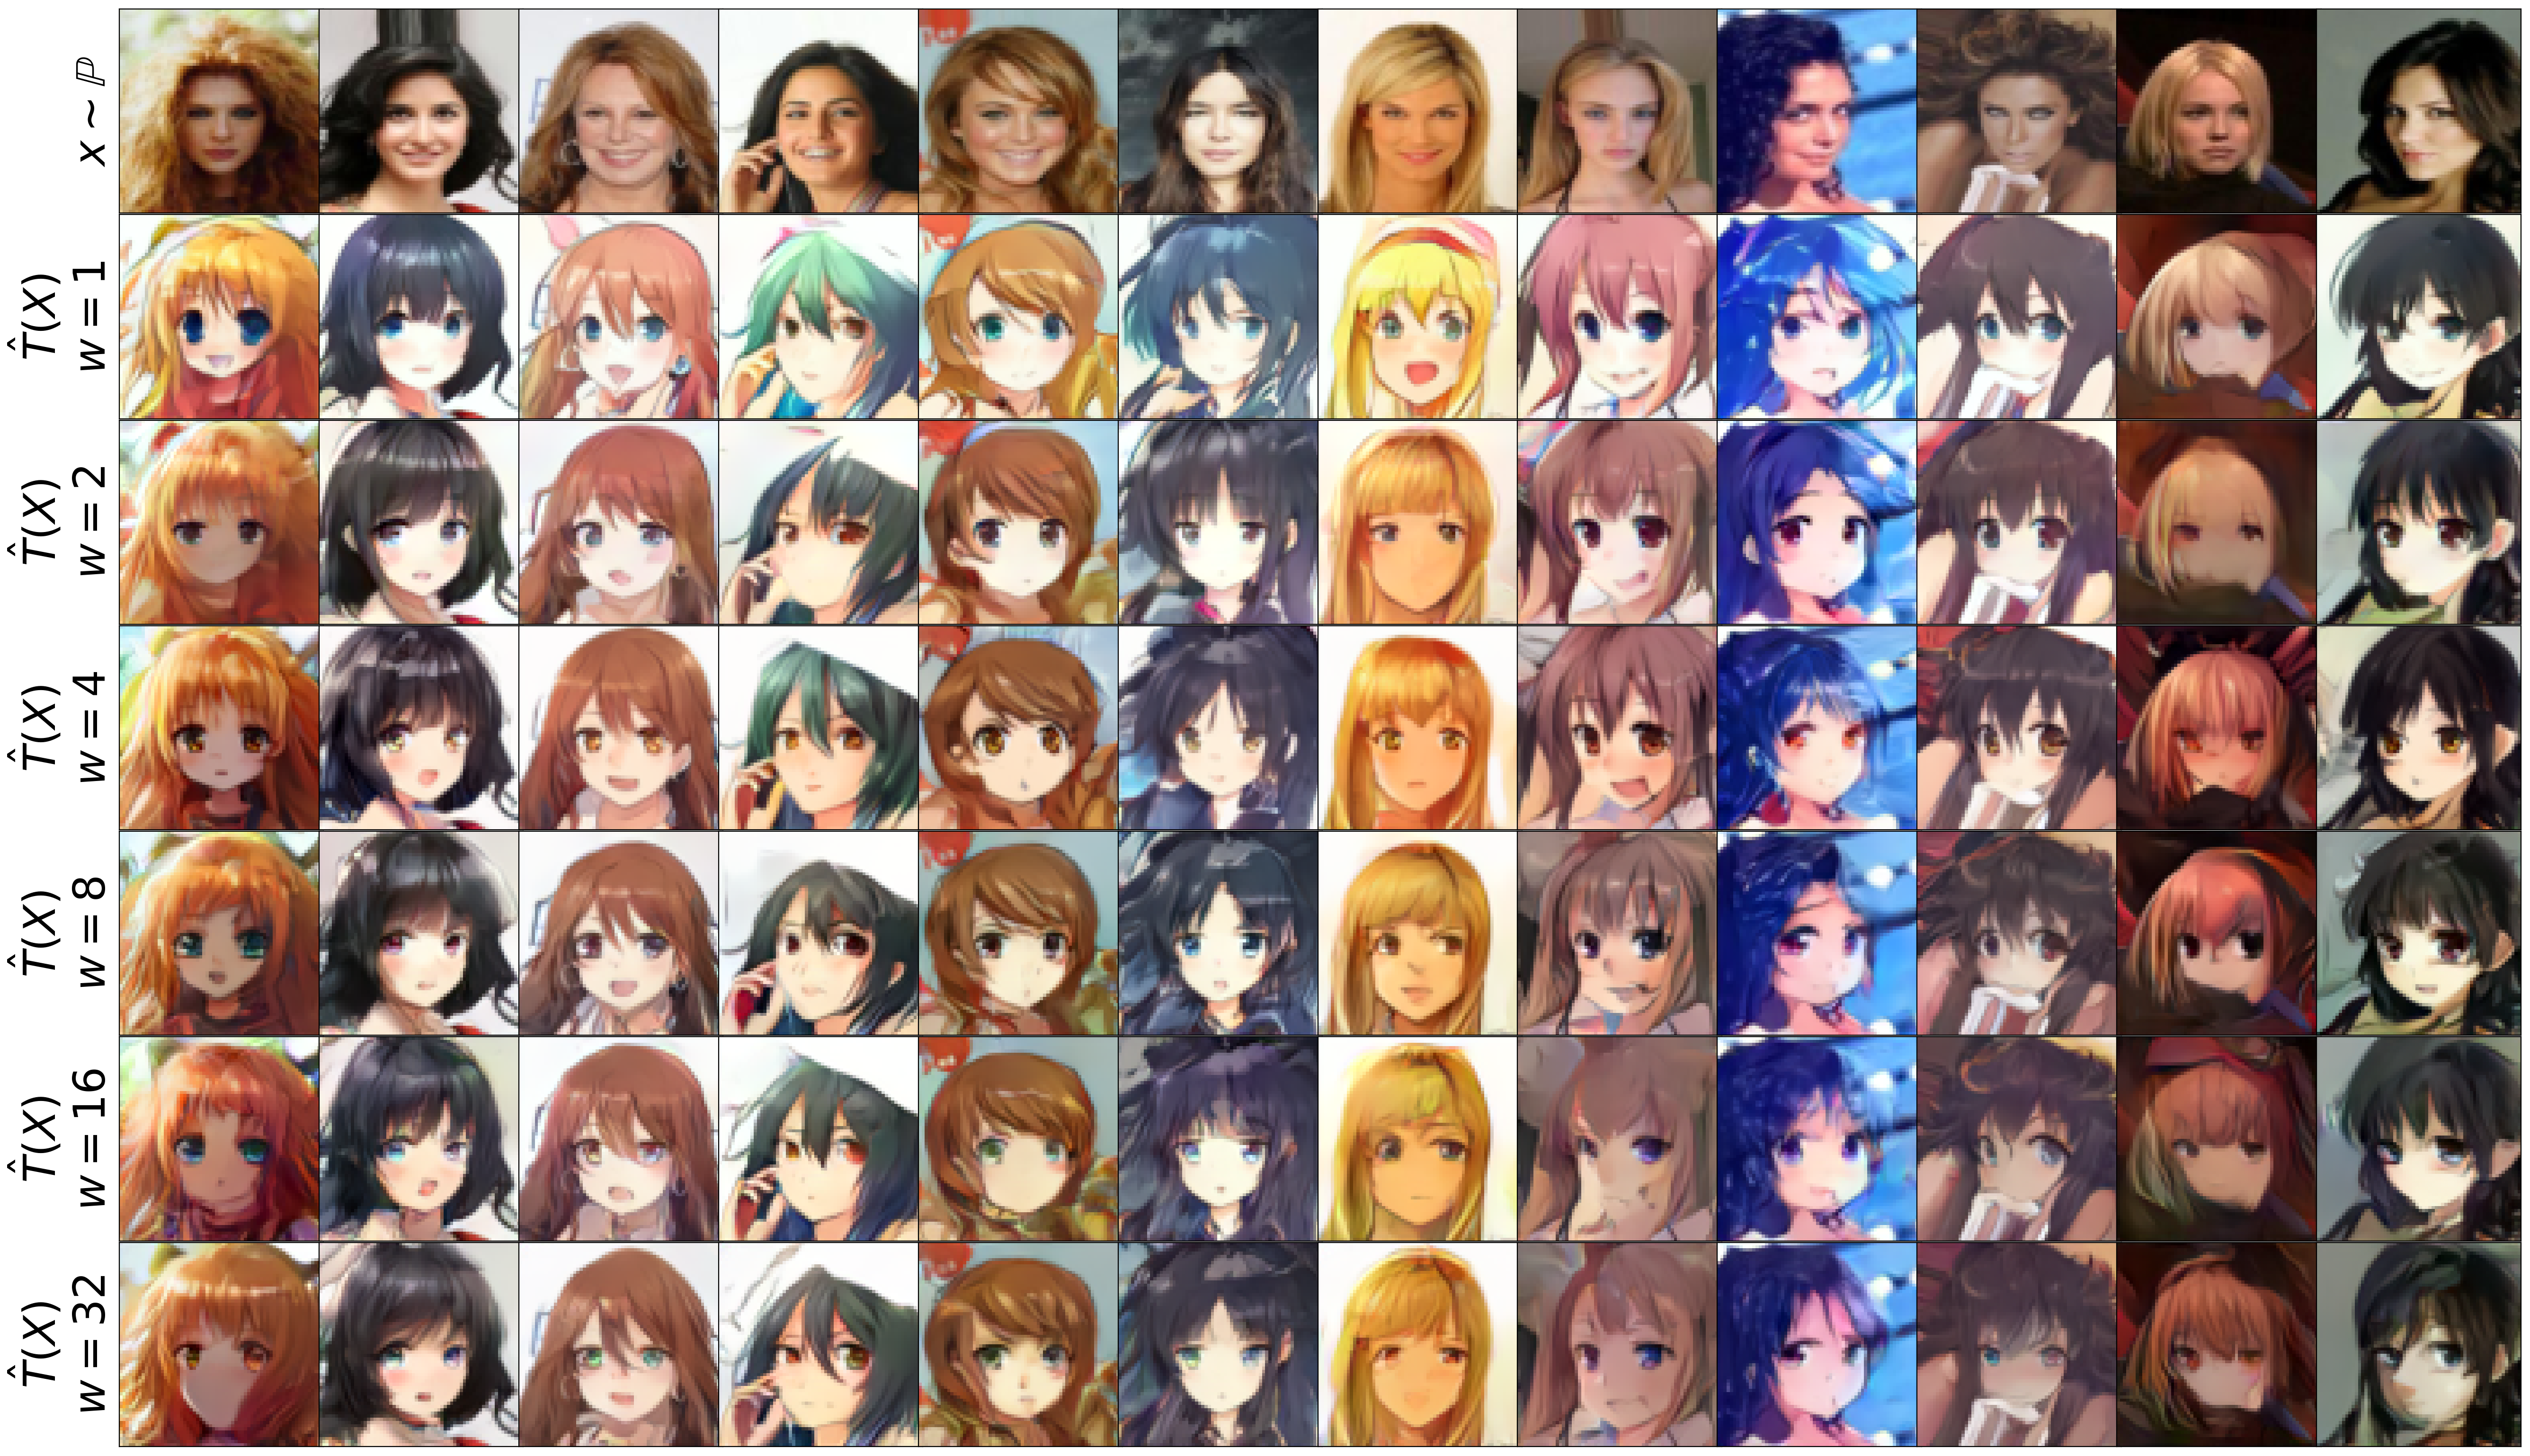

In [28]:
indices = [0, 243, 2, 35, 189, 246, 101, 102, 104, 105, 107, 108] #[]  #[i for i in range(140, 150)]#[0, 243, 2, 35, 189, 246]
for W in [1, 2, 4, 8, 16, 32]:
    with torch.no_grad():
        PATH = '../checkpoints/{}_{}_{}_{}_{}_{}_{}.pt'.format(COST, DATASET1, DATASET2, IMG_SIZE, 64, 48, W)
        if W == 16:
            PATH = '../checkpoints/{}_{}_{}_{}_{}_{}_{}.pt'.format(COST, DATASET1, DATASET2, IMG_SIZE, 128, 48, W)
        try:
            T.load_state_dict(torch.load(PATH))
        except:
            T.module.load_state_dict(torch.load(PATH))
    for i in range(len(indices)):
        X = dataset[indices[i]][0][None].cuda()
        if i == 0 and W == 1:
            T_X = T(X)
            Xs = X
        else:
            T_X = torch.cat([T_X, T(X)])
            if W == 1:
                Xs = torch.cat([Xs, X])
        
imgs = torch.cat([Xs, T_X])        
imgs = imgs.detach().to('cpu').permute(0,2,3,1).mul(0.5).add(0.5).numpy().clip(0,1)

fig, axes = plt.subplots(7, len(indices), figsize=(2*len(indices)+2.5, 2*7+1.2), dpi=200)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])

for i in range(0, 6):   
    j = 2**i
    axes[i+1, 0].set_ylabel('$\hat{T}(X)$\n$w=$%d'%j, fontsize=33)
    
axes[0, 0].set_ylabel('$x\sim\mathbb{P}$', fontsize=33)

fig.tight_layout(pad=0.001)
torch.cuda.empty_cache(); gc.collect()

### Main figure

1266

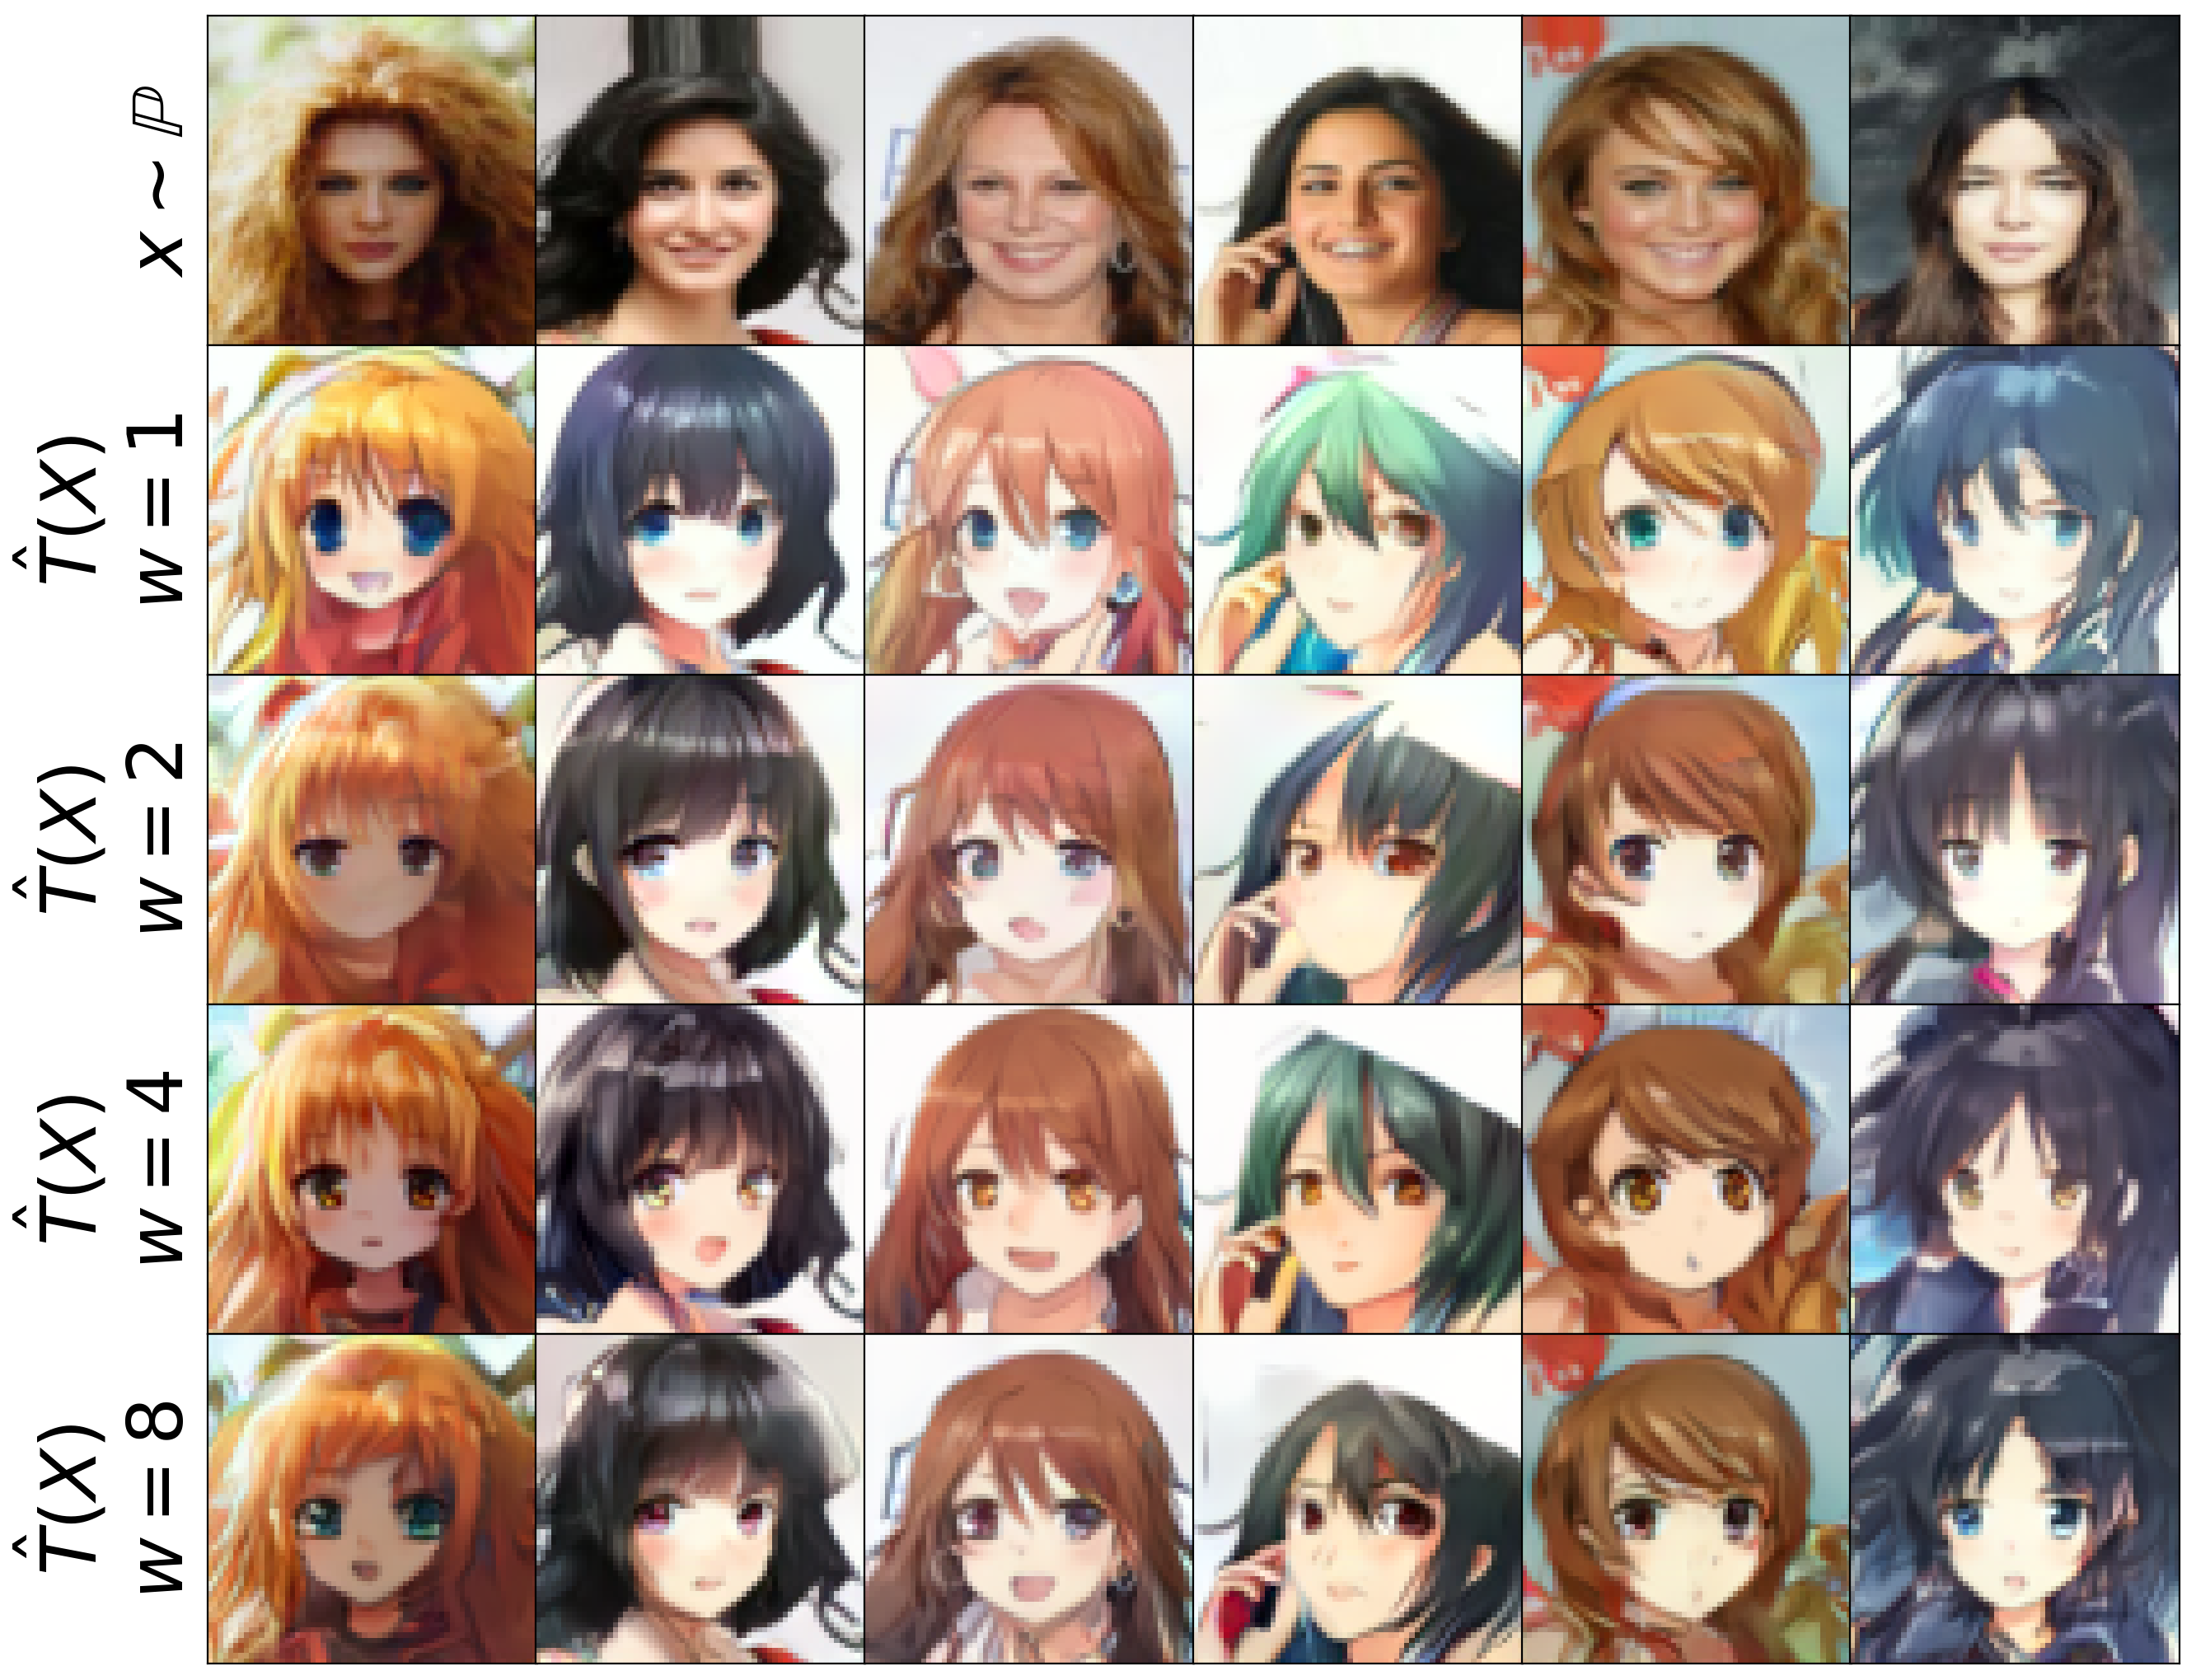

In [17]:
indices = [0, 243, 2, 35, 189, 246]
for W in [1, 2, 4, 8]:
    with torch.no_grad():
        PATH = '../checkpoints/{}_{}_{}_{}_{}_{}_{}.pt'.format(COST, DATASET1, DATASET2, IMG_SIZE, 64, 48, W)
        try:
            T.load_state_dict(torch.load(PATH))
        except:
            T.module.load_state_dict(torch.load(PATH))
    for i in range(len(indices)):
        X = dataset[indices[i]][0][None].cuda()
        if i == 0 and W == 1:
            T_X = T(X)
            Xs = X
        else:
            T_X = torch.cat([T_X, T(X)])
            if W == 1:
                Xs = torch.cat([Xs, X])
        
imgs = torch.cat([Xs, T_X])        
imgs = imgs.detach().to('cpu').permute(0,2,3,1).mul(0.5).add(0.5).numpy().clip(0,1)

fig, axes = plt.subplots(5, len(indices), figsize=(2*len(indices)+1.2, 2*5), dpi=200)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])

for i in range(0, 4):   
    j = 2**i
    axes[i+1, 0].set_ylabel('$\hat{T}(X)$\n$w=$%d'%j, fontsize=33)
    
axes[0, 0].set_ylabel('$x\sim\mathbb{P}$', fontsize=33)

fig.tight_layout(pad=0.001)
torch.cuda.empty_cache(); gc.collect()

## Handbag -> shoes

In [6]:
Y_full = torch.zeros((0, IMG_SIZE*IMG_SIZE*3))
for i in range(100):
    Y = Y_test_sampler.sample().cuda()
    Y = Y.reshape(Y.shape[0], Y.shape[1]*Y.shape[2]*Y.shape[3])
    Y_full = torch.cat((Y_full, Y.cpu().detach()))
emb_Y = PCA(n_components=2).fit(Y_full)
del Y, Y_full

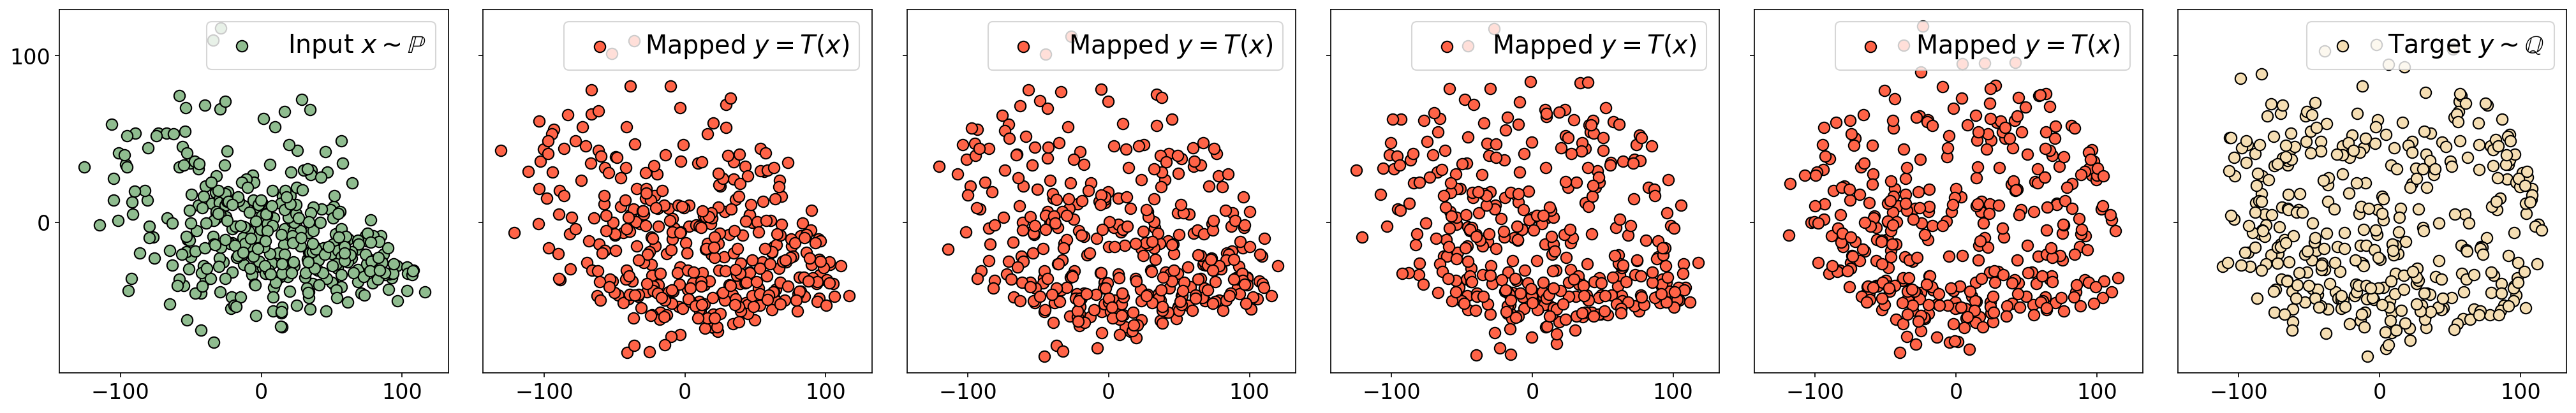

In [36]:
freeze(T)
    
X_full = torch.zeros((0, IMG_SIZE*IMG_SIZE*3))
Y_full = torch.zeros((0, IMG_SIZE*IMG_SIZE*3))
T_X_full = [torch.zeros((0, IMG_SIZE*IMG_SIZE*3)), torch.zeros((0, IMG_SIZE*IMG_SIZE*3)), 
            torch.zeros((0, IMG_SIZE*IMG_SIZE*3)), torch.zeros((0, IMG_SIZE*IMG_SIZE*3))]
for i in tqdm(tqdm(range(100))):
    X = X_test_sampler.sample().cuda()
    Y = Y_test_sampler.sample().cuda()
    for i, w in enumerate([1, 2, 4, 8]):
        PATH = 'state_dicts/{}_{}_{}_{}_{}_{}_{}.pt'.format(COST, DATASET1, 
                                                            DATASET2, IMG_SIZE, 64, 48, w)
        T.load_state_dict(torch.load(PATH))
        T.cuda()
        T_X = T(X)
        T_X = T_X.reshape(T_X.shape[0], T_X.shape[1]*T_X.shape[2]*T_X.shape[3])
        T_X_full[i] = torch.cat((T_X_full[i], T_X.cpu().detach()))
        del T_X
    X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])
    Y = Y.reshape(Y.shape[0], Y.shape[1]*Y.shape[2]*Y.shape[3])
    X_full = torch.cat((X_full, X.cpu().detach()))
    Y_full = torch.cat((Y_full, Y.cpu().detach()))

X = emb_Y.transform(X_full)
Y = emb_Y.transform(Y_full)

labelsize = 16; fontsize = 19;
fig, axes = plt.subplots(1, 6, figsize=(3*6+9, 3*1+1.4), dpi=150, sharex=True, sharey=True)
axes[0].scatter(X[:384, 0], X[:384, 1], c='darkseagreen', edgecolors='black', zorder=3, label=r'Input $x\sim\mathbb{P}$', s=70)
for i, w in enumerate([1, 2, 4, 8]):
    T_X = emb_Y.transform(T_X_full[i])
    axes[4-i].scatter(T_X[:384, 0], T_X[:384, 1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $y=T(x)$', s=70)
    axes[4-i].legend(loc='upper right', fontsize=fontsize)
    axes[4-i].locator_params(nbins=4)
    axes[4-i].tick_params(labelsize=labelsize)
axes[-1].scatter(Y[:384, 0], Y[:384, 1], c='wheat', edgecolors='black', 
                 label=r'Target $y\sim\mathbb{Q}$', s=70)

axes[0].legend(loc='upper right', fontsize=fontsize); axes[-1].legend(loc='upper right', fontsize=fontsize); 
axes[0].tick_params(labelsize=labelsize); axes[-1].tick_params(labelsize=labelsize)

fig.tight_layout(pad=1)

(25, 128, 128, 3)


51385

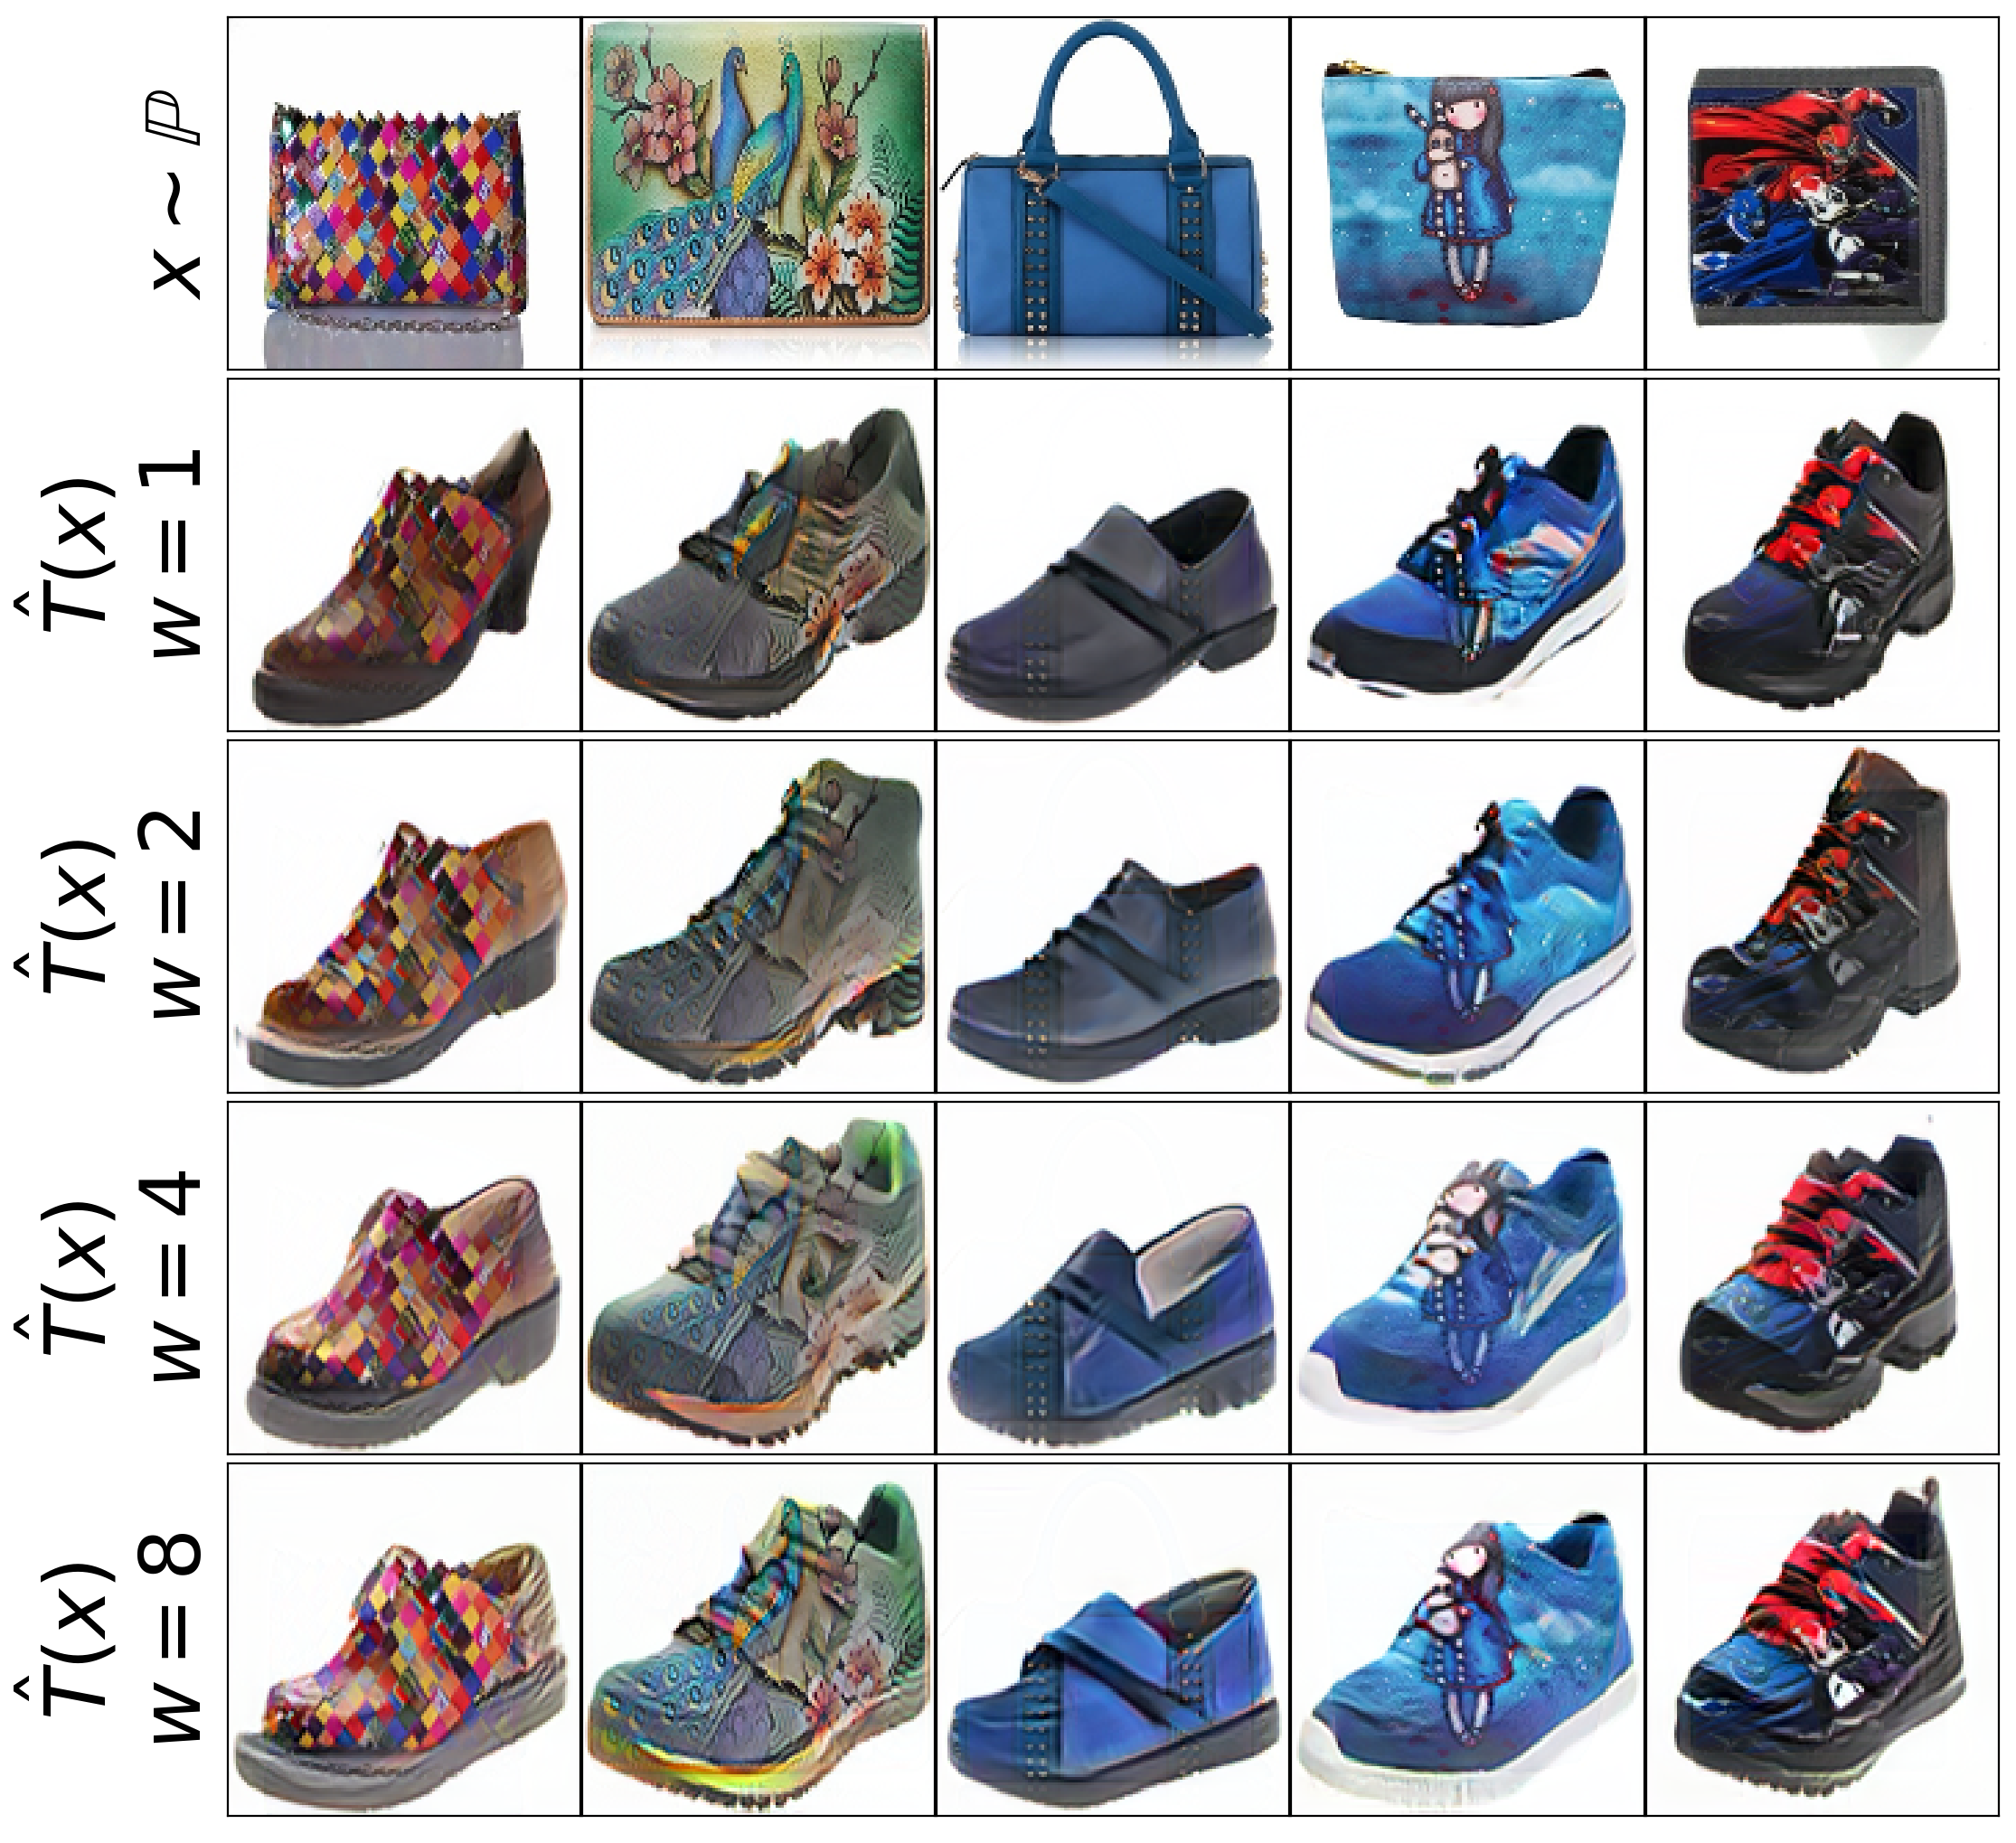

In [9]:
dataset = X_test_sampler.loader.dataset
indices = [0, 243, 947, 1030, 906]
for W in [1, 2, 4, 8]:
    with torch.no_grad():
        PATH = '../checkpoints/{}_{}_{}_{}_{}_{}_{}.pt'.format(COST, DATASET1, DATASET2, IMG_SIZE, 64, 48, W)
        T.load_state_dict(torch.load(PATH, map_location='cpu'))
        T.to(DEVICE)
    for i in range(len(indices)):
        X = dataset[indices[i]][0][None].to(DEVICE)
        if i == 0 and W == 1:
            T_X = T(X)
            Xs = X
        else:
            T_X = torch.cat([T_X, T(X)])
            if W == 1:
                Xs = torch.cat([Xs, X])
        
imgs = torch.cat([Xs, T_X])        
imgs = imgs.detach().to('cpu').permute(0,2,3,1).mul(0.5).add(0.5).numpy().clip(0,1)

print(imgs.shape)
fig, axes = plt.subplots(5, len(indices), figsize=(2*len(indices)+1, 2*5), dpi=200)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])

for i in range(0, 4):   
    j = 2**i
    axes[i+1, 0].set_ylabel('$\hat{T}(x)$\n$w=$%d'%j, fontsize=33)
    
axes[0, 0].set_ylabel('$x\sim\mathbb{P}$', fontsize=33)

fig.tight_layout(pad=0.001)
torch.cuda.empty_cache(); gc.collect()

## Dtd->Chairs

In [7]:
dataset = X_test_sampler.loader.dataset

(60, 64, 64, 3)


198048

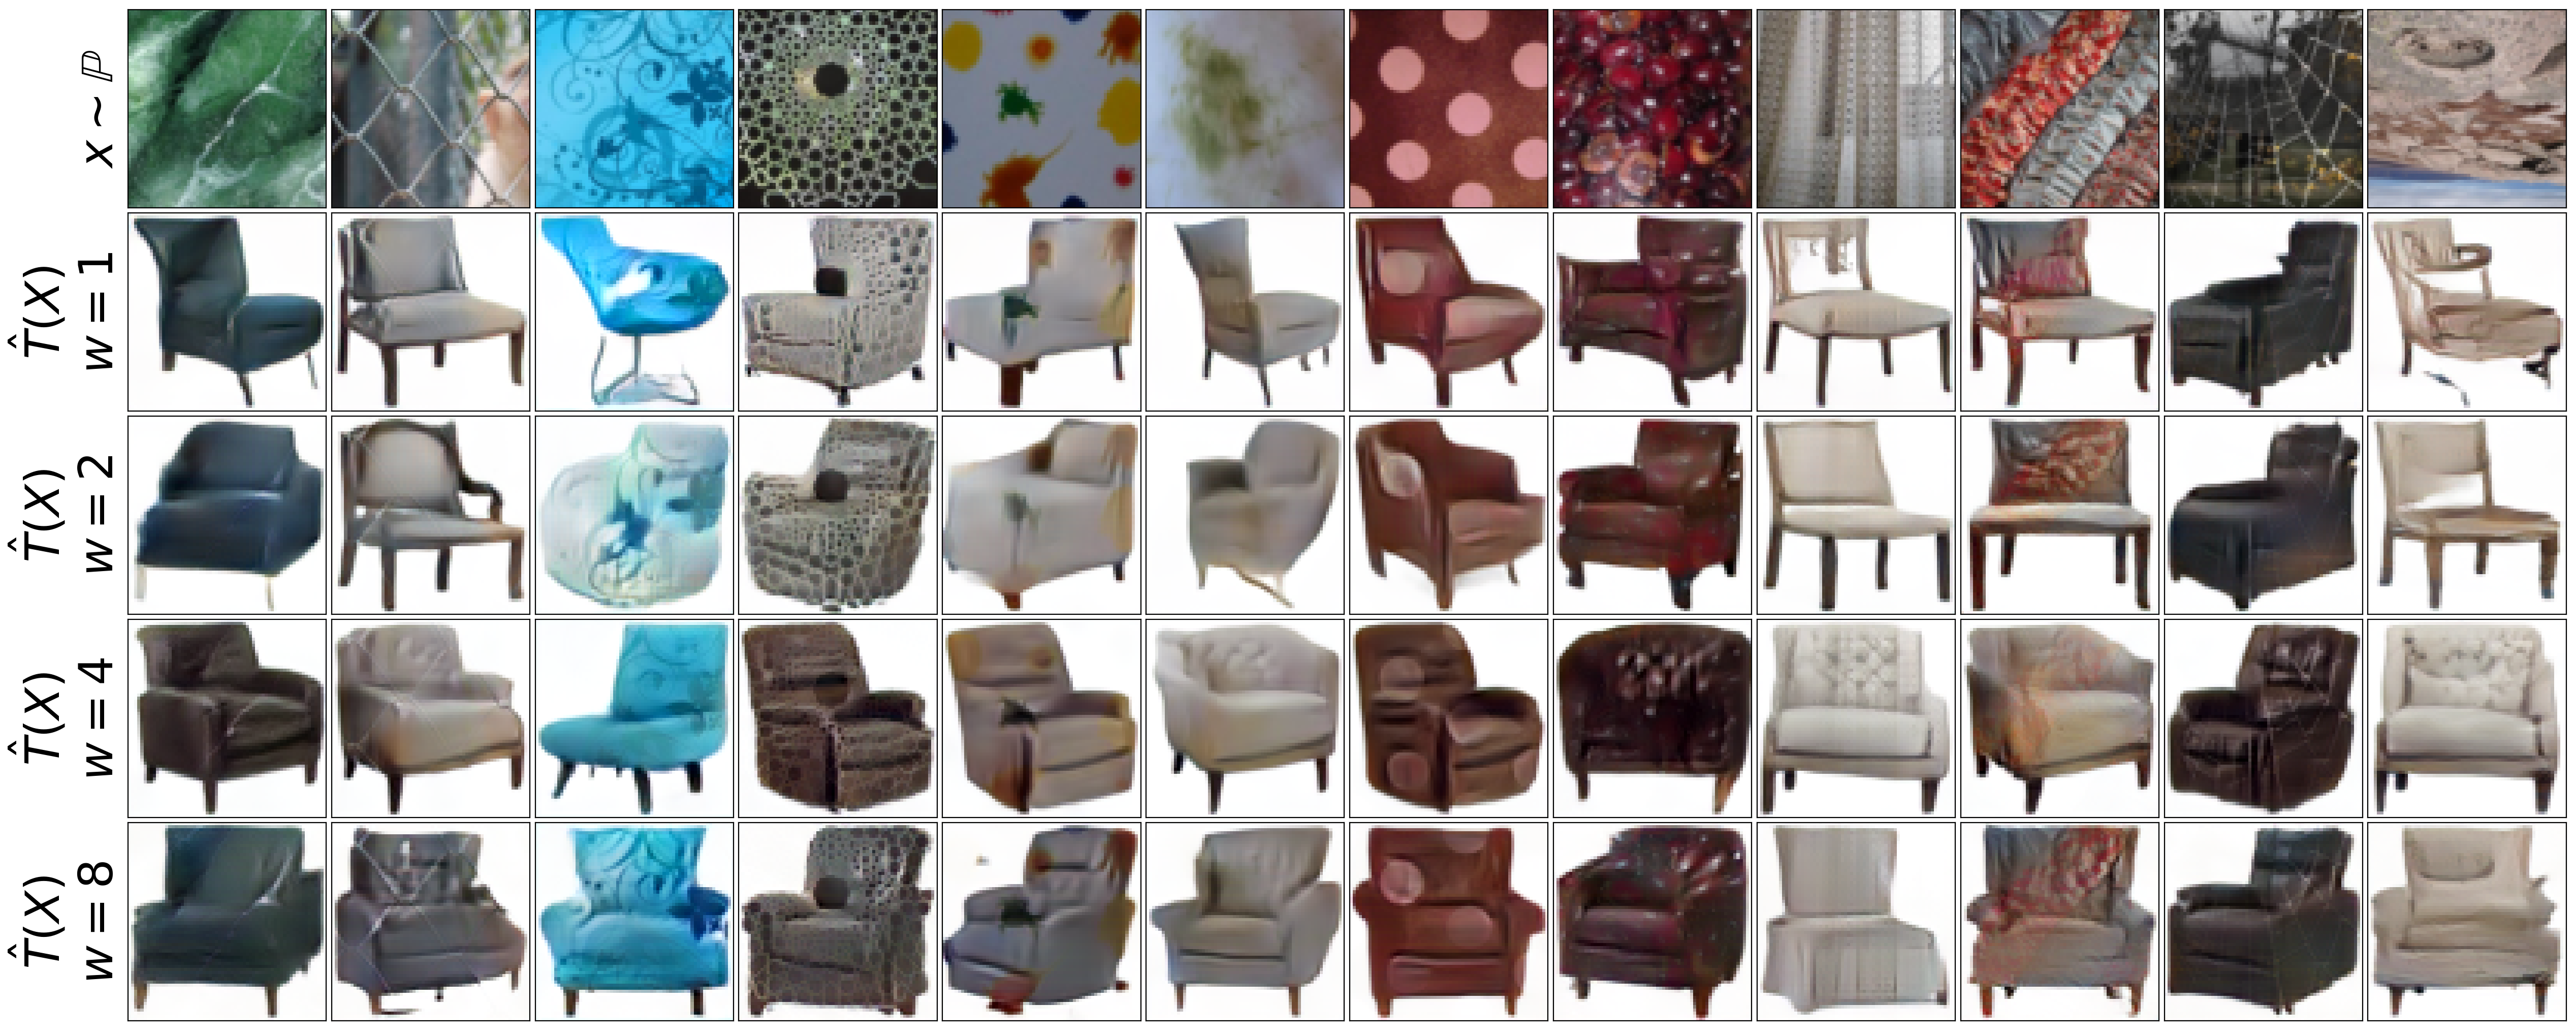

In [16]:
indices = [i for i in range(340, 360)]

for W in [1, 2, 4, 8]:
    with torch.no_grad():
        PATH = 'checkpoints/{}_{}_{}_{}_{}_{}_{}.pt'.format(COST, DATASET1, DATASET2, IMG_SIZE, 64, 48, W)
        T.load_state_dict(torch.load(PATH))
        T.to(DEVICE)
    for i in range(len(indices)):
        X = dataset[indices[i]][0][None].cuda()
        if i == 0 and W == 1:
            T_X = T(X[i])
            Xs = X[i]
        else:
            T_X = torch.cat([T_X, T(X[i])])
            if W == 1:
                Xs = torch.cat([Xs, X[i]])
        
imgs = torch.cat([Xs, T_X])     
imgs = imgs.detach().to('cpu').permute(0,2,3,1).mul(0.5).add(0.5).numpy().clip(0,1)

print(imgs.shape)
fig, axes = plt.subplots(5, len(indices), figsize=(2*len(indices)+1.2, 2*5), dpi=200)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])

for i in range(0, 4):   
    j = 2**i
    axes[i+1, 0].set_ylabel('$\hat{T}(X)$\n$w=$%d'%j, fontsize=33)
    
axes[0, 0].set_ylabel('$x\sim\mathbb{P}$', fontsize=33)

fig.tight_layout(pad=0.001)
torch.cuda.empty_cache(); gc.collect()

## FFHQ->Comic_faces

(30, 128, 128, 3)


1697

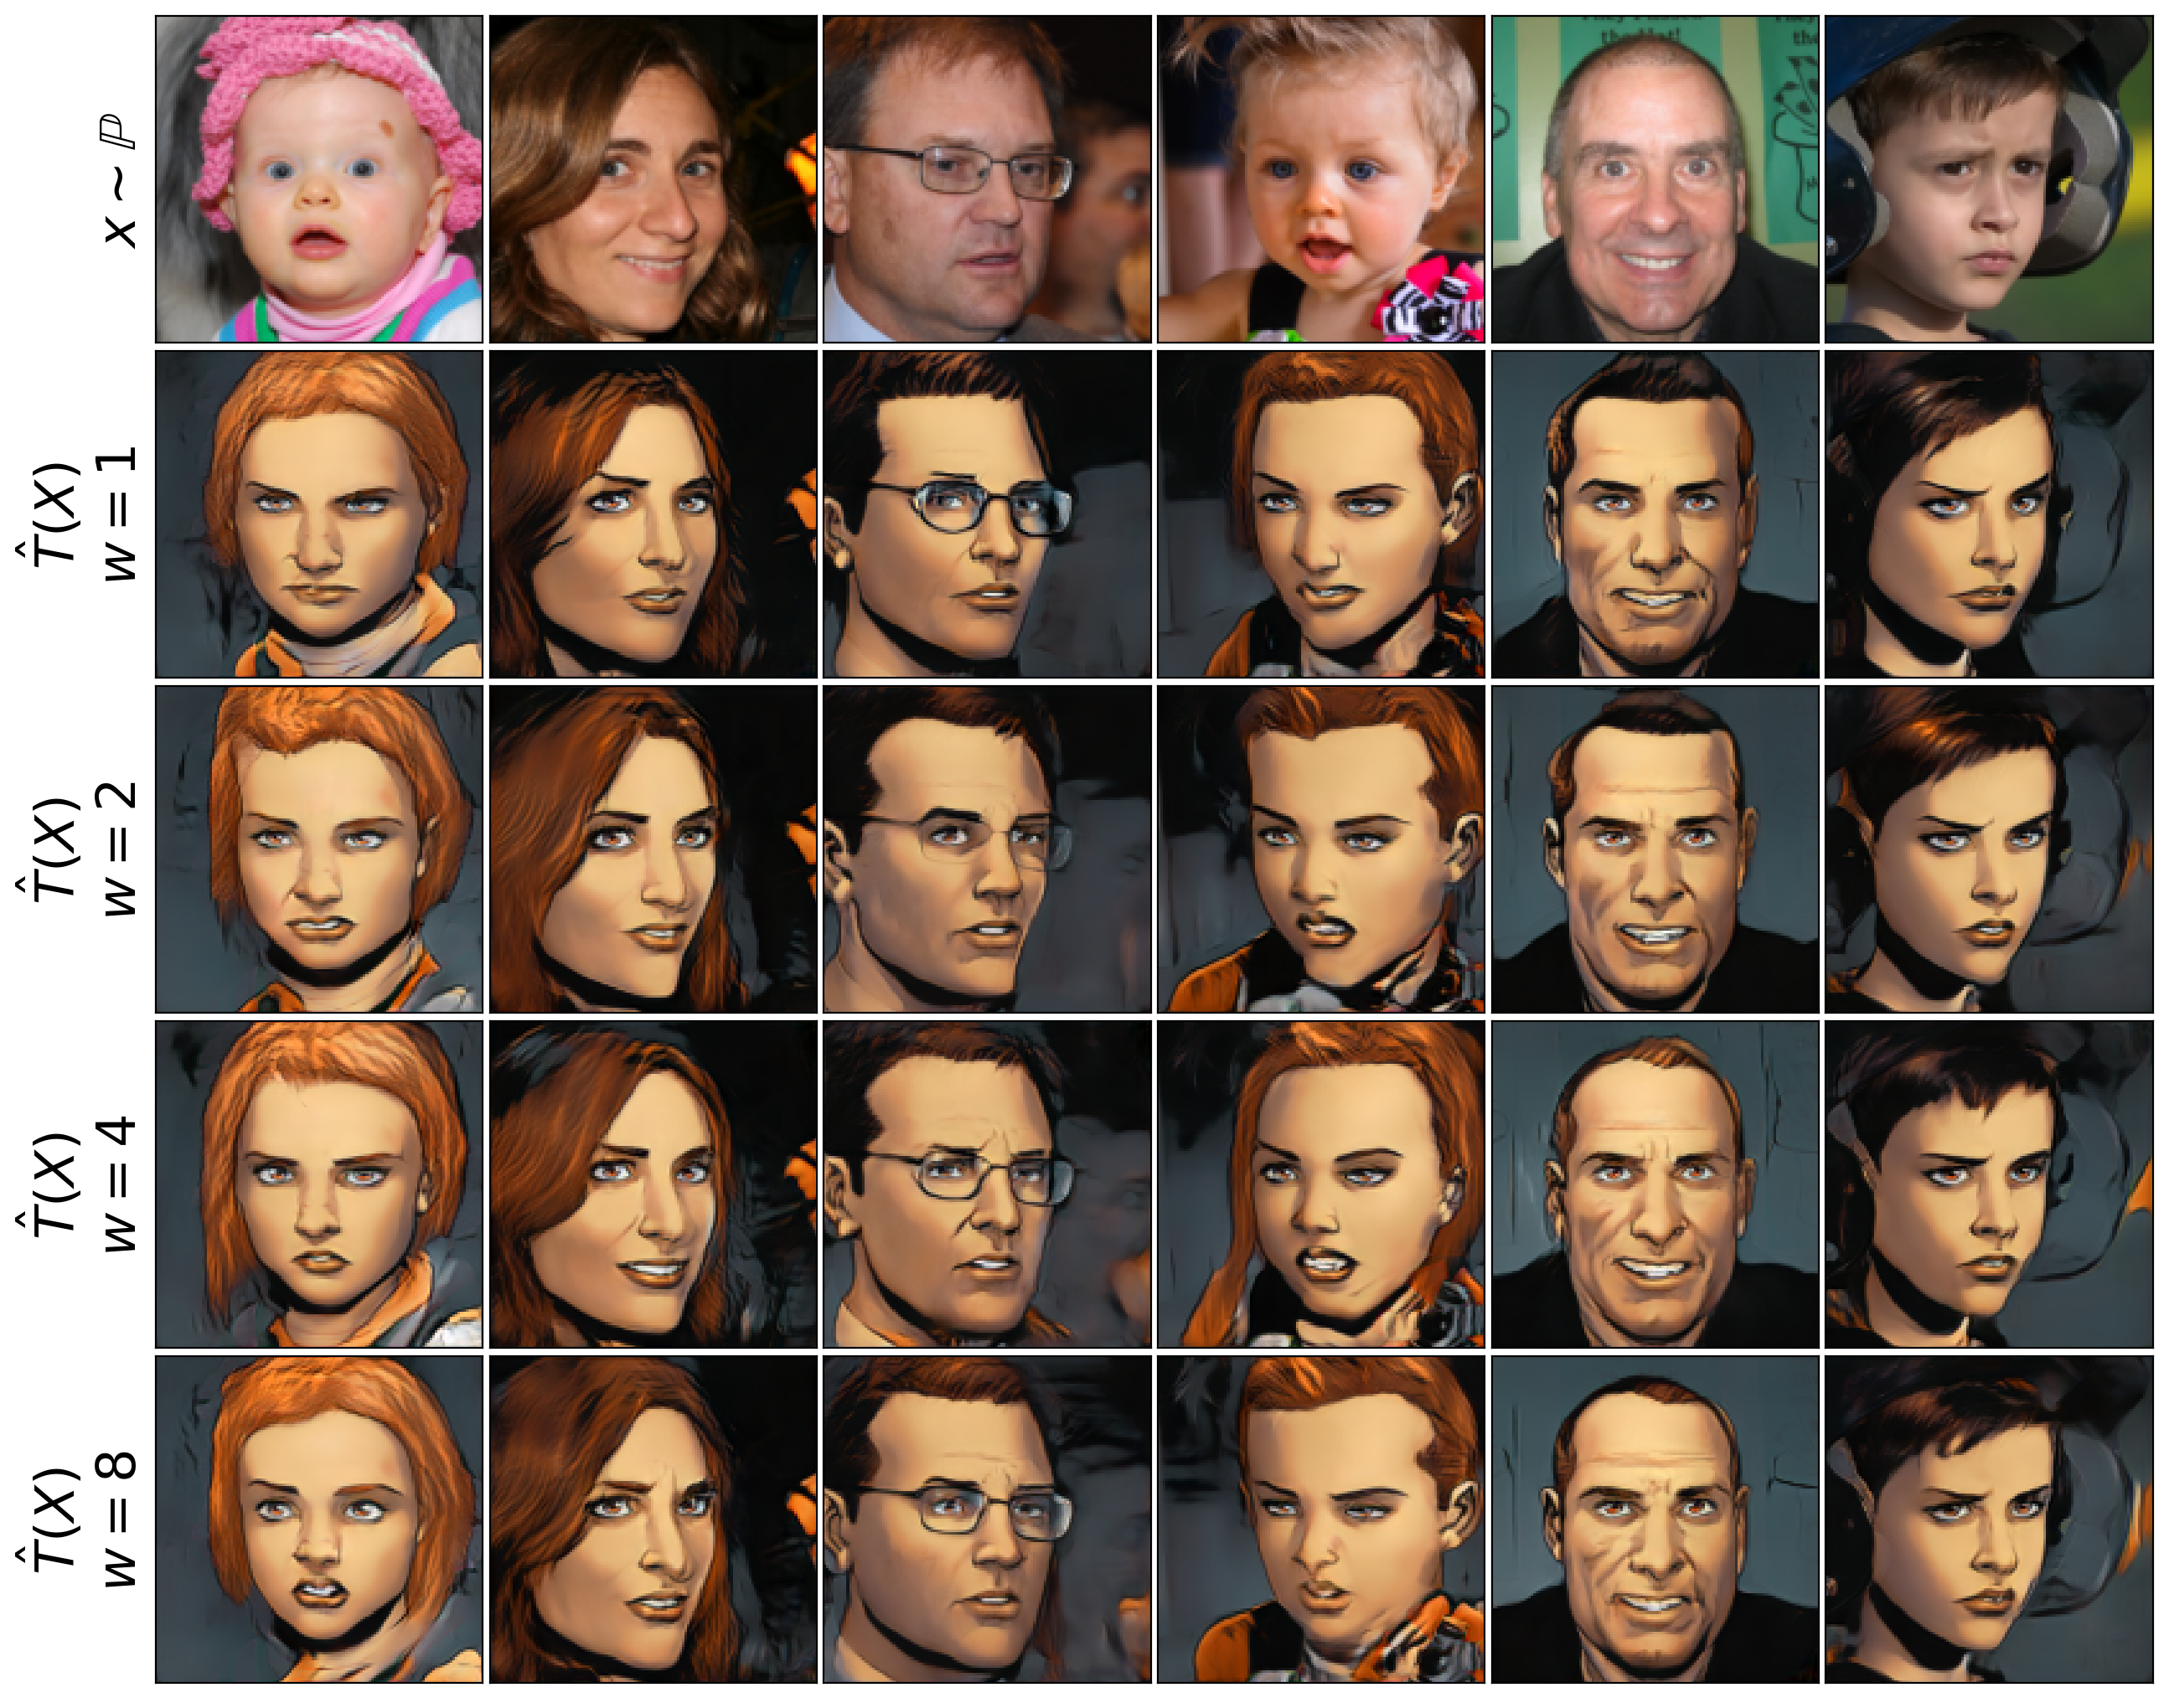

In [19]:
dataset = X_test_sampler.loader.dataset
indices = [1, 243, 167, 211, 314, 317] 
for W in [1, 2, 4, 8]:
    with torch.no_grad():
        PATH = 'checkpoints/{}_{}_{}_{}_{}_{}_{}.pt'.format(COST, DATASET1, DATASET2, IMG_SIZE, 64, 48, W)
        T.load_state_dict(torch.load(PATH, map_location='cpu'))
        T.to(DEVICE)        
    for i in range(len(indices)):
        X = dataset[indices[i]][0][None].to(DEVICE)
        if i == 0 and W == 1:
            T_X = T(X)
            Xs = X
        else:
            T_X = torch.cat([T_X, T(X)])
            if W == 1:
                Xs = torch.cat([Xs, X])
        
imgs = torch.cat([Xs, T_X])        
imgs = imgs.detach().to('cpu').permute(0,2,3,1).mul(0.5).add(0.5).numpy().clip(0,1)

print(imgs.shape)
fig, axes = plt.subplots(5, len(indices), figsize=(2*len(indices)+0.8, 2*5), dpi=200)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])

for i in range(0, 4):   
    j = 2**i
    axes[i+1, 0].set_ylabel('$\hat{T}(X)$\n$w=$%d'%j, fontsize=23)
    
axes[0, 0].set_ylabel('$x\sim\mathbb{P}$', fontsize=23)

fig.tight_layout(pad=0.001)
torch.cuda.empty_cache(); gc.collect()